In [124]:
import tensorflow as tf
import numpy as np
import os
from keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Input, ZeroPadding2D, BatchNormalization, Activation, MaxPooling2D, Flatten, Dense
from tensorflow.keras.models import Model, load_model
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.layers.normalization import BatchNormalization


In [125]:
import zipfile,os
local_zip = '/tmp/braintumor.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

In [126]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy') > 0.97):
      print("\n Akurasi di atas 97%, Training berhenti!")
      self.model.stop_training = True

callbacks = myCallback()

In [127]:
base_dir = '/tmp/brain_tumor_dataset'
train_dir = os.path.join(base_dir,'train')
validation_dir = os.path.join(base_dir, 'val')
yes_dir = os.path.join(base_dir,'yes')
no_dir = os.path.join(base_dir, 'no')


In [128]:
os.mkdir(train_dir)
os.mkdir(validation_dir)

FileExistsError: ignored

In [129]:
train_yes = os.path.join(train_dir, 'yes')
train_no = os.path.join(train_dir, 'no')
val_yes = os.path.join(validation_dir, 'yes')
val_no = os.path.join(validation_dir, 'no')

In [130]:
os.mkdir(train_yes)
os.mkdir(train_no)
os.mkdir(val_yes)
os.mkdir(val_no)

FileExistsError: ignored

In [131]:
from sklearn.model_selection import train_test_split
train_yes_dir, val_yes_dir = train_test_split(os.listdir(yes_dir), test_size = 0.40)
train_no_dir, val_no_dir = train_test_split(os.listdir(no_dir), test_size = 0.40)


In [132]:
import shutil

for file in train_yes_dir:
  shutil.copy(os.path.join(yes_dir, file), os.path.join(train_yes, file))
for file in train_no_dir:
  shutil.copy(os.path.join(no_dir,file), os.path.join(train_no,file))

for file in val_yes_dir:
  shutil.copy(os.path.join(yes_dir, file), os.path.join(val_yes,file))
for file in val_no_dir:
  shutil.copy(os.path.join(no_dir,file), os.path.join(val_no,file))


In [133]:
train_datagen = ImageDataGenerator(
    rescale = 1./255,
    rotation_range = 20,
    zoom_range=0.2,
    horizontal_flip = True,
    shear_range = 0.2,
    fill_mode = 'nearest',
)
test_datagen = ImageDataGenerator(
    rescale = 1./225,
    rotation_range = 20,
    horizontal_flip = True,
    vertical_flip = True,
    zoom_range=0.2,
    shear_range = 0.2,
    fill_mode = 'nearest'
)

In [134]:
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size= 8,
    color_mode='rgb',
    class_mode='binary'

)

validation_generator = test_datagen.flow_from_directory(
    validation_dir,
    target_size = (150, 150),
    batch_size = 8,
    color_mode='rgb',
    class_mode = 'binary'

)

Found 208 images belonging to 2 classes.
Found 159 images belonging to 2 classes.


In [136]:
sample_train_images, _ = next(train_generator)
sample_val_images, _ = next(validation_generator)

def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

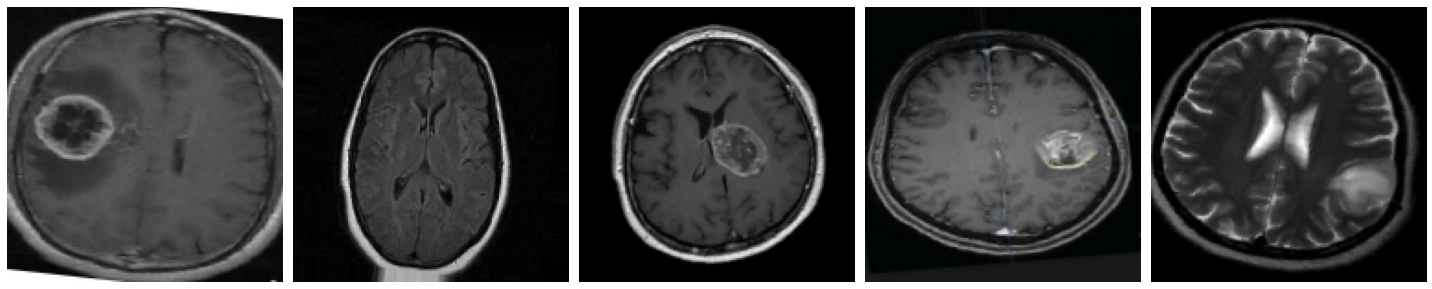

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


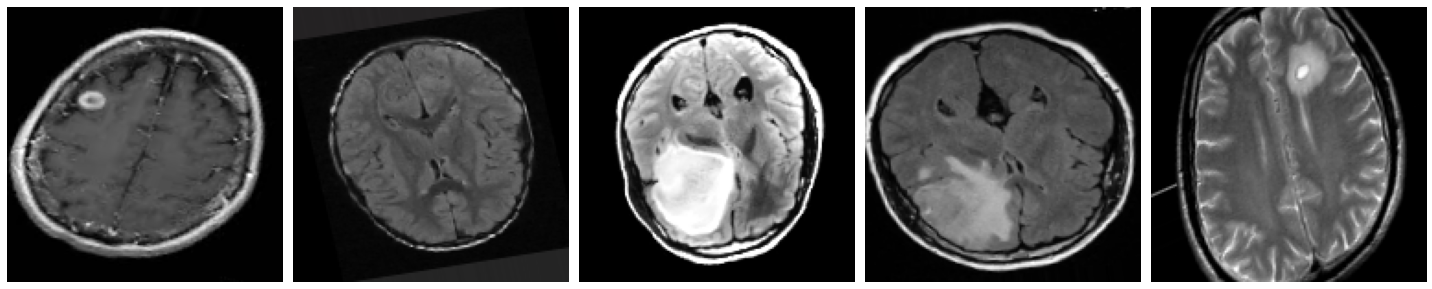

In [137]:
import matplotlib.pyplot as plt

plotImages(sample_train_images[:5])
plotImages(sample_val_images[:5])

In [142]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv2D(32, (3,3), activation = 'relu',strides=(1,1), input_shape= (150,150,3)),
  tf.keras.layers.MaxPooling2D(2,2),
  tf.keras.layers.Conv2D(64,(3,3),strides=(1,1), activation= 'relu'),
  tf.keras.layers.MaxPooling2D(2,2),
  tf.keras.layers.Conv2D(128,(3,3),strides=(1,1), activation= 'relu'),
  tf.keras.layers.MaxPooling2D(2,2),  
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dropout(0.5),
  tf.keras.layers.Dense(512, activation= 'relu'),
  tf.keras.layers.Dense(1, activation='sigmoid')
])

model.summary()
model.compile(loss='binary_crossentropy',
              optimizer=tf.optimizers.Adam(),
              metrics=['accuracy'])

Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_55 (Conv2D)           (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_55 (MaxPooling (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_56 (Conv2D)           (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_56 (MaxPooling (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_57 (Conv2D)           (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_57 (MaxPooling (None, 17, 17, 128)       0         
_________________________________________________________________
flatten_18 (Flatten)         (None, 36992)           

In [143]:
history = model.fit(
    train_generator,
    steps_per_epoch = 26, 
    epochs = 20,
    validation_data = validation_generator,
    validation_steps = 19, 
    verbose =1,
      callbacks=[callbacks]
)

Epoch 1/20
26/26 [==============================] - 17s 627ms/step - loss: 1.0281 - accuracy: 0.6099 - val_loss: 0.6487 - val_accuracy: 0.6579
Epoch 2/20
26/26 [==============================] - 16s 609ms/step - loss: 0.6007 - accuracy: 0.7699 - val_loss: 0.7649 - val_accuracy: 0.5526
Epoch 3/20
26/26 [==============================] - 16s 612ms/step - loss: 0.6040 - accuracy: 0.6853 - val_loss: 0.5638 - val_accuracy: 0.7237
Epoch 4/20
26/26 [==============================] - 16s 635ms/step - loss: 0.5713 - accuracy: 0.7737 - val_loss: 0.5659 - val_accuracy: 0.7434
Epoch 5/20
26/26 [==============================] - 21s 802ms/step - loss: 0.4748 - accuracy: 0.8221 - val_loss: 0.5744 - val_accuracy: 0.7105
Epoch 6/20
26/26 [==============================] - 16s 619ms/step - loss: 0.5850 - accuracy: 0.6915 - val_loss: 0.5042 - val_accuracy: 0.7763
Epoch 7/20
26/26 [==============================] - 16s 609ms/step - loss: 0.5012 - accuracy: 0.7752 - val_loss: 0.4988 - val_accuracy: 0.7763

In [144]:
history = model.fit(
    train_generator,
    steps_per_epoch = 26, 
    epochs = 20,
    validation_data = validation_generator,
    validation_steps = 19, 
    verbose =1,
      callbacks=[callbacks]
)

Epoch 1/20
26/26 [==============================] - 16s 621ms/step - loss: 0.3364 - accuracy: 0.8654 - val_loss: 0.4828 - val_accuracy: 0.7763
Epoch 2/20
26/26 [==============================] - 16s 618ms/step - loss: 0.3155 - accuracy: 0.8510 - val_loss: 0.3943 - val_accuracy: 0.8224
Epoch 3/20
26/26 [==============================] - 16s 618ms/step - loss: 0.3919 - accuracy: 0.8558 - val_loss: 0.4299 - val_accuracy: 0.8158
Epoch 4/20
26/26 [==============================] - 16s 617ms/step - loss: 0.3659 - accuracy: 0.8606 - val_loss: 0.4329 - val_accuracy: 0.8355
Epoch 5/20
26/26 [==============================] - 16s 616ms/step - loss: 0.3675 - accuracy: 0.8510 - val_loss: 0.4243 - val_accuracy: 0.7895
Epoch 6/20
26/26 [==============================] - 16s 614ms/step - loss: 0.2831 - accuracy: 0.8702 - val_loss: 0.5007 - val_accuracy: 0.7961
Epoch 7/20
26/26 [==============================] - 16s 613ms/step - loss: 0.3577 - accuracy: 0.8413 - val_loss: 0.4632 - val_accuracy: 0.8158

In [145]:
history = model.fit(
    train_generator,
    steps_per_epoch = 26, 
    epochs = 10,
    validation_data = validation_generator,
    validation_steps = 19, 
    verbose =1,
      callbacks=[callbacks]
)

Epoch 1/10
26/26 [==============================] - 16s 615ms/step - loss: 0.2150 - accuracy: 0.9087 - val_loss: 0.6204 - val_accuracy: 0.7763
Epoch 2/10
26/26 [==============================] - 16s 613ms/step - loss: 0.2963 - accuracy: 0.8702 - val_loss: 0.4320 - val_accuracy: 0.8355
Epoch 3/10
26/26 [==============================] - 16s 610ms/step - loss: 0.2706 - accuracy: 0.8798 - val_loss: 0.3554 - val_accuracy: 0.8816
Epoch 4/10
26/26 [==============================] - 16s 613ms/step - loss: 0.2184 - accuracy: 0.9279 - val_loss: 0.4327 - val_accuracy: 0.8289
Epoch 5/10
26/26 [==============================] - 16s 611ms/step - loss: 0.2267 - accuracy: 0.9087 - val_loss: 0.3918 - val_accuracy: 0.8553
Epoch 6/10
26/26 [==============================] - 16s 616ms/step - loss: 0.2013 - accuracy: 0.9038 - val_loss: 0.5993 - val_accuracy: 0.8224
Epoch 7/10
26/26 [==============================] - 16s 614ms/step - loss: 0.2482 - accuracy: 0.8654 - val_loss: 0.3823 - val_accuracy: 0.8684

In [146]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

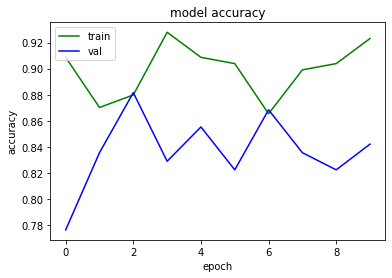

In [147]:
plt.plot(acc, color='green')
plt.plot(val_acc, color='blue')
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

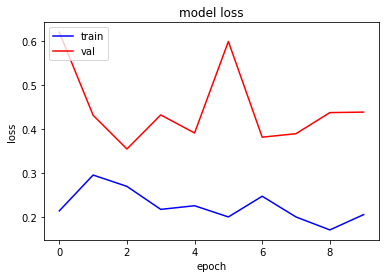

In [148]:
plt.plot(loss, color='blue')
plt.plot(val_loss, color='red')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

Saving 8 no.jpg to 8 no.jpg
8 no.jpg
no


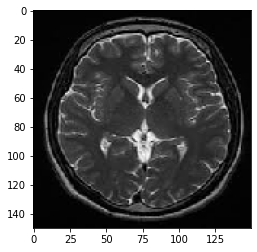

In [158]:
import numpy as np
from google.colab import files
from keras.preprocessing import image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

uploaded = files.upload()

for fn in uploaded.keys():
 
  # predicting images
  path = fn
  img = image.load_img(path, target_size=(150,150))
  imgplot = plt.imshow(img)
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)

  images = np.vstack([x])
  classes = model.predict(images, batch_size=8)
  print(fn)
  if classes==0:
    print('no')
  else:
    print('yes')